## PINN for Burger's Equation in TensorFlow

Burger's equation is a fundamental partial differential equation occuring in various areas of applied mathematics such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. For a given $u(x,t)$ and diffusion coefficient $\nu$, the general form of Burgers' equation in one-dimension is given by

$$\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}.$$

[[Wikipedia]](https://en.wikipedia.org/wiki/Burgers%27_equation)

Based on our notation of class, we are trying to solve

$$ D_u(t,x) = \frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0.$$

In [5]:
!pip install gdown -q
!pip install pyDOE
import gdown

gdown.download('https://drive.google.com/uc?id=1QieqpAiJz8WDBA5ANT4BcGHFIwKIw7Yq', output='burgers_shock.mat', quiet=True)

'burgers_shock.mat'

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# Setting random number generators
np.random.seed(seed=1234)
tf.random.set_seed(1234)

# Ensuring that we are using a full float32 precision
tf.config.experimental.enable_tensor_float_32_execution(False)

In this section we implement $u$ and $D_u$ as neural networks, and a training step. The latter defines the cost as
$$ C = L_O + L_D = \frac{1}{N_O} \sum_i(f_\theta(t_i,x_i)-u_i)^2 + \frac{1}{N_D}\sum_j D_u(t_j,x_j)^2. $$

In [7]:
# Defining a general MLP with tanh activation functions. Note that we will use 'X' to represent 'x'
# and 't' stacked together.
def MLP(X, W, b):
    # Initializing the hidden state
    h = X

    # Iterating over the layers
    noLayers = len(W)
    for i in range(noLayers-1):
        h = tf.tanh(tf.add(tf.matmul(h, W[i]), b[i]))

    # Applying a linear transformation for the output layer
    Y = tf.add(tf.matmul(h, W[-1]), b[-1])

    return Y

# Specifying the architecture for u
def net_u(x, t, W, b):
    u = MLP(tf.concat([x,t],1), W, b)
    return u

# Specifying the architecture of D_u.
# We use the @tf.function decorator to speed up the execution.
@tf.function()
def net_Du(x, t, W, b, nu):
    # Gradient tape is used to keep track of the portions of the computlational graph used for
    # computing gradients (as opposed to keep track of every computation for every variable, which
    # would be inefficient).
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u = net_u(x,t, W, b)
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
    u_xx = tape1.gradient(u_x, x)
    Du = u_t + u*u_x - nu*u_xx
    return Du

# Defining a training step.
@tf.function()
def train_step(W, b, Xu_train_tf, u_train_tf, XD_train_tf, opt, nu):
    # Splitting the 'x' and 't' values used for training. We are using indexing in this format to
    # maintain the extra dimension on the array when extracting it. Otherwise, we would need to do
    # a reshape.
    xu = Xu_train_tf[:,0:1]
    tu = Xu_train_tf[:,1:2]
    xD = XD_train_tf[:,0:1]
    tD = XD_train_tf[:,1:2]

    # Computing the loss as specified in the text above.
    with tf.GradientTape() as tape:
        tape.watch([W, b])
        u_nn = net_u(xu, tu, W, b)
        Du_nn = net_Du(xD, tD, W, b, nu)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(Du_nn))

    # Computing the gradients and applying a step of optimization
    grads = tape.gradient(loss, W+b)
    opt.apply_gradients(zip(grads, W+b))

    return loss

Loading the data

In [8]:
# Loading data
data = scipy.io.loadmat('./burgers_shock.mat')

# Displaying content
for key, value in data.items():
  if key[0]=='_':
    print(key, ': ', value)
  else:
    print(key, ': ', value.shape)

__header__ :  b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017'
__version__ :  1.0
__globals__ :  []
x :  (256, 1)
t :  (100, 1)
usol :  (256, 100)


t Dimensions =  (100, 1)
x Dimensions =  (256, 1)
u Dimensions =  (100, 256)


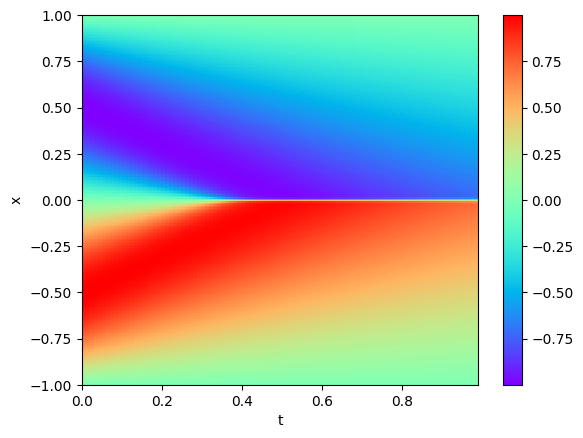

In [9]:
# Parsing the data
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
u = np.real(data['usol']).T

# Setting the viscocity value
nu = tf.constant(0.01/np.pi)

# Displaying dimensions of the data
print('t Dimensions = ', t.shape)
print('x Dimensions = ', x.shape)
print('u Dimensions = ',u.shape)

# Plotting the solution
h = plt.imshow(u.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
plt.colorbar(h)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Extracting the initial and boundary conditions.

In [10]:
# Creating stacked versions of X = (x,t) and u.
xGrid, tGrid = np.meshgrid(x,t)
XStack = np.hstack((xGrid.flatten()[:,None], tGrid.flatten()[:,None]))
uStack = u.flatten()[:,None]

# Domain bounds
lb = XStack.min(0)
ub = XStack.max(0)

# Initial Condition at t=0
X0 = np.hstack((xGrid[0:1,:].T, tGrid[0:1,:].T))
u0 = u[0:1,:].T

# Boundary condition at x=-1
X1 = np.hstack((xGrid[:,0:1], tGrid[:,0:1]))
u1 = u[:,0:1]

# Boundary condition at x=1
X2 = np.hstack((xGrid[:,-1:], tGrid[:,-1:]))
u2 = u[:,-1:]

Creating the training set.

In [11]:
from pyDOE import lhs

# Specifying the number of Initial and Boundary data points
noObs = 200
# Specifying the number of residual point
noDyn = 10000

# We combine initial and boundary conditions in a single array and take a subset for training
Xu_total = np.vstack([X0, X1, X2])
u_total = np.vstack([u0, u1, u2])
idx = np.random.choice(Xu_total.shape[0], noObs, replace=False)
Xu_train = Xu_total[idx, :]
u_train = u_total[idx,:]
#Xu_train = Xu_total
#u_train = u_total

# Generating random set of points in the (x,t)-domain and appending all X points. That is to make
# that the dynamics are satisfied in the random domain as well as the specified boundary.
XD_train = lb + (ub-lb)*lhs(2, noDyn)
XD_train = np.vstack((XD_train, Xu_total))

# Turning the training sets into tensors
Xu_train_tf = tf.convert_to_tensor(Xu_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
XD_train_tf = tf.convert_to_tensor(XD_train, dtype=tf.float32)

Displaying the points randomly selected to satisfy the dynamics.

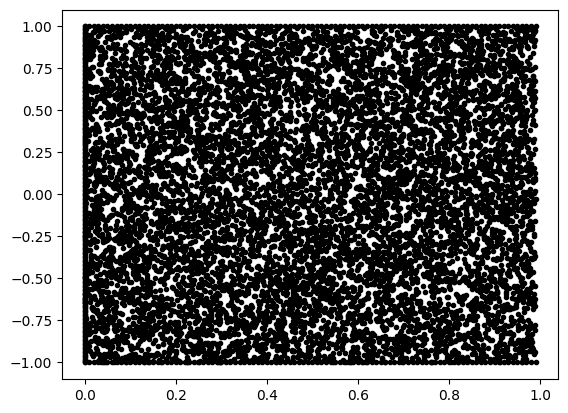

In [12]:
plt.plot(XD_train[:,1],XD_train[:,0],'k.')
plt.show()

Training the model

In [13]:
# Specifying the number of iterations of optimization
noIter = 10000

# Specifying the dimensions of the layers in the MLP
layers = [2, 32, 32, 32, 1]
noLayers = len(layers)

# Function to initilize the weights of the network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Initializing the layers
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, noLayers)]
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, noLayers)]

# Setting up optimizer
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

# Running optimization
lossHistory = []
for n in range(0,noIter):
    loss_ = train_step(W, b, Xu_train_tf, u_train_tf, XD_train_tf, optimizer, nu)
    lossHistory.append(loss_)
    if (n+1) % 1000 == 0:
        print(f"Iteration is: {n+1} and loss is: {loss_}")

Iteration is: 1000 and loss is: 0.05532350391149521
Iteration is: 2000 and loss is: 0.04893065243959427
Iteration is: 3000 and loss is: 0.03526805341243744
Iteration is: 4000 and loss is: 0.018285444006323814
Iteration is: 5000 and loss is: 0.00746507104486227
Iteration is: 6000 and loss is: 0.003950188867747784
Iteration is: 7000 and loss is: 0.0028902555350214243
Iteration is: 8000 and loss is: 0.002287164330482483
Iteration is: 9000 and loss is: 0.0018891629297286272
Iteration is: 10000 and loss is: 0.012979520484805107


Displaying learning curve

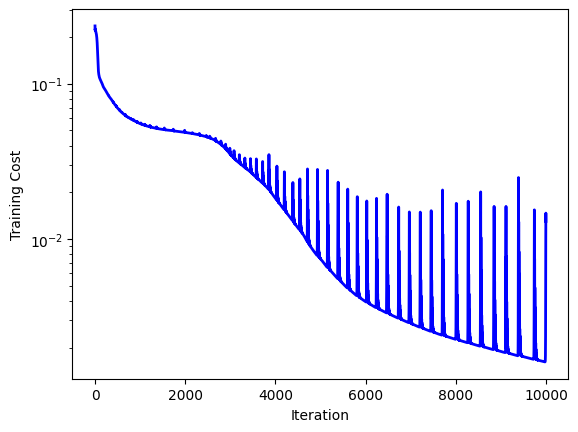

In [14]:
it = np.arange(0, len(lossHistory), 1)
loss_list = [lossHistory[i].numpy() for i in range(0,len(lossHistory))]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2)
plt.xlabel('Iteration')
plt.ylabel('Training Cost')
plt.show()

Performing prediction

In [15]:
# Defining prediction function
def predict(X_tf, W, b):
    x_star = X_tf[:,0:1]
    t_star = X_tf[:,1:2]
    u_pred = net_u(x_star, t_star, W, b)
    return u_pred

def predictDu(X_tf, W, b, nu):
    x_star = X_tf[:,0:1]
    t_star = X_tf[:,1:2]
    Du_pred = net_Du(x_star, t_star, W, b, nu)
    return Du_pred

# Computing the error in the prediction
XStack_tf = tf.convert_to_tensor(XStack, dtype=tf.float32)
uStackPred = predict(XStack_tf, W, b)
uPred = np.reshape(uStackPred,u.shape)
error_u = np.linalg.norm(uStack-uStackPred,2)/np.linalg.norm(uStack,2)
print('Relative Error u: %e' %(error_u))

# Computing remainder for D_u
Du2StackPred = np.square(predictDu(XStack_tf, W, b, nu))
Du2Pred = np.reshape(Du2StackPred,u.shape)
error_Du = np.mean(Du2StackPred)
print('Remainder D_u: %e' %(error_Du))

Relative Error u: 2.051777e-01
Remainder D_u: 9.221323e-03


Plotting results

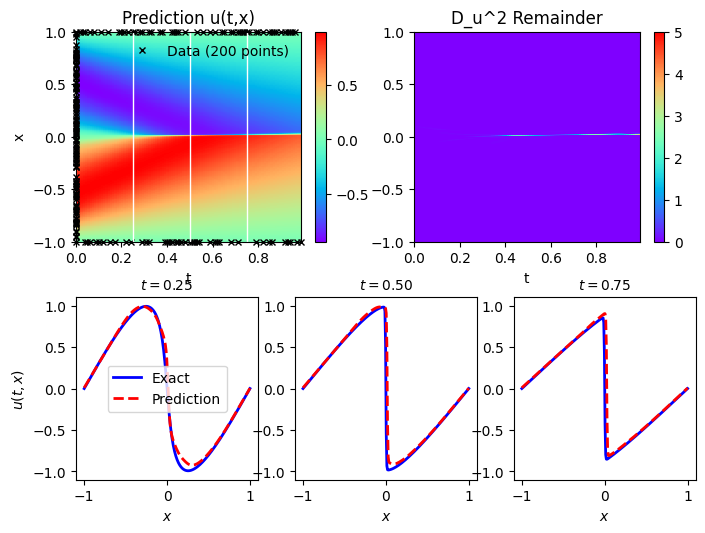

In [16]:
# Plotting the prediction
fig = plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
h = plt.imshow(uPred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
plt.colorbar(h)
plt.xlabel('t')
plt.ylabel('x')
plt.title('Prediction u(t,x)')

# Plotting the training points
plt.plot(Xu_train[:,1], Xu_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
plt.legend(frameon=False, loc = 'best')

# Plotting the lines corresponding to the slices shown below
line = np.linspace(x.min(), x.max(), 2)[:,None]
plt.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
plt.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
plt.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

# Plotting the D_u^2 remainder
plt.subplot(2,2,2)
h = plt.imshow(Du2Pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
plt.colorbar(h)
plt.xlabel('t')
plt.title('D_u^2 Remainder')

# Displaying slices
plt.subplot(2,3,4)
plt.plot(x,u[25,:], 'b-', linewidth = 2, label = 'Exact')
plt.plot(x,uPred[25,:], 'r--', linewidth = 2, label = 'Prediction')
plt.xlabel('$x$')
plt.ylabel('$u(t,x)$')
plt.title('$t = 0.25$', fontsize = 10)
plt.axis('square')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.legend(loc='best')

plt.subplot(2,3,5)
plt.plot(x,u[50,:], 'b-', linewidth = 2, label = 'Exact')
plt.plot(x,uPred[50,:], 'r--', linewidth = 2, label = 'Prediction')
plt.xlabel('$x$')
plt.title('$t = 0.50$', fontsize = 10)
plt.axis('square')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

plt.subplot(2,3,6)
plt.plot(x,u[75,:], 'b-', linewidth = 2, label = 'Exact')
plt.plot(x,uPred[75,:], 'r--', linewidth = 2, label = 'Prediction')
plt.xlabel('$x$')
plt.title('$t = 0.75$', fontsize = 10)
plt.axis('square')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

plt.show()